# Network descriptive statistics
In this notebook, I'll explore descriptive statistics and analyses about my citation network(s). This will include things like topic modelling in addition to more simple statistics. For the moment, I'm going to work with the Semantic Scholar dataset, so statistics about citations should be taken with a grain of salt.

In [86]:
import jsonlines
import requests
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import networkx as nx
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

ModuleNotFoundError: No module named 'gensim'

In [2]:
# Import API key. This must be requested from https://www.semanticscholar.org/product/api#api-key; we save ours in an untracked file in data and import here
import sys
sys.path.append('../data/')
from semantic_scholar_API_key import API_KEY
header = {'x-api-key': API_KEY}

## Reading in the dataset

In [3]:
with jsonlines.open('../data/semantic_scholar/desiccation_tolerance_10000_with_fixed_rev_cit_23Oct2023.jsonl') as reader:
    papers = []
    for obj in reader:
        papers.append(obj)

In [4]:
# Wrangling into a flattened object with paperID as indexer to eliminate redundant papers for analyses where we don't
# care about the connectivity of the network
flattened_papers = {}
for p in papers:
    try:
        flattened_papers[p['paperId']] = {'title': p['title'], 'abstract': p['abstract']}
    except KeyError:
        flattened_papers[p['paperId']] = {'title': p['title']}
    for r in p['references']:
        try:
            flattened_papers[r['paperId']] = {'title': r['title'], 'abstract': r['abstract']}
        except KeyError:
            flattened_papers[r['paperId']] = {'title': r['title']}

In [5]:
# Using old classification from before generic bugfix for the moment
classified = nx.read_graphml('../data/citation_network/full_10000_with_classification_19Sep2023.graphml')

In [35]:
paper_classifications = {k: v['study_system'] for k, v in classified.nodes(data=True)}

## Simple descriptive statistics
### Number of papers

In [7]:
print(f'There are {len(flattened_papers)} unique papers in the dataset')

There are 193243 unique papers in the dataset


### Number of papers per year
I didn't grab the years in my initial retrieval; will do this now

In [8]:
num_batches = len(flattened_papers)//500 + 1
num_batches, num_batches*500

(387, 193500)

In [9]:
to_retrieve = list(flattened_papers.keys())

In [10]:
papers_with_years = []
for i in range(num_batches):
    ids = to_retrieve[i*500:(i+1)*500]
    succeeded = False
    while not succeeded:
        r = requests.post(
            'https://api.semanticscholar.org/graph/v1/paper/batch',
            params={'fields': 'year'},
            json={"ids": ids},
            headers=header
        ).json()
        if type(r) == list:
            succeeded = True
        else:
            print(f'Request number {i} failed, trying again')
    papers_with_years.extend(r)  

Request number 2 failed, trying again
Request number 75 failed, trying again
Request number 168 failed, trying again
Request number 168 failed, trying again
Request number 169 failed, trying again
Request number 171 failed, trying again
Request number 176 failed, trying again
Request number 176 failed, trying again
Request number 183 failed, trying again
Request number 189 failed, trying again
Request number 191 failed, trying again
Request number 194 failed, trying again
Request number 280 failed, trying again
Request number 299 failed, trying again
Request number 299 failed, trying again
Request number 300 failed, trying again
Request number 300 failed, trying again
Request number 304 failed, trying again
Request number 316 failed, trying again
Request number 320 failed, trying again
Request number 326 failed, trying again
Request number 327 failed, trying again
Request number 331 failed, trying again
Request number 332 failed, trying again
Request number 332 failed, trying again
Req

In [21]:
len(papers_with_years)

193243

In [22]:
len([p for p in papers_with_years if p is None])

14

In [23]:
paper_years = [p['year'] for p in papers_with_years if (p is not None) and (p['year'] is not None)]

In [24]:
len(paper_years)

192499

Text(0, 0.5, 'Count')

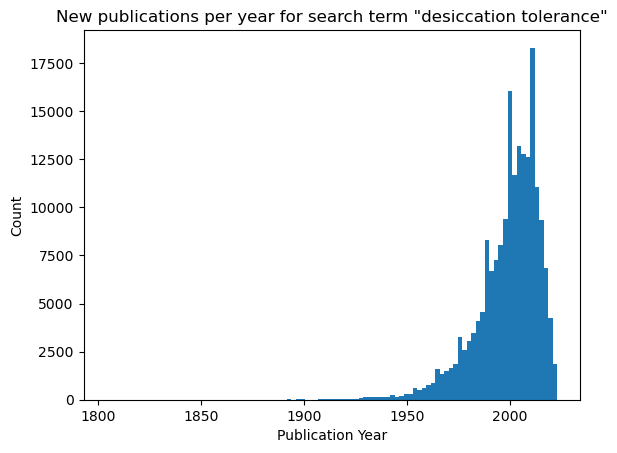

In [25]:
_ = plt.hist(paper_years, bins=100)
plt.title('New publications per year for search term "desiccation tolerance"')
plt.xlabel('Publication Year')
plt.ylabel('Count')

Here we can see that the field of desiccation tolerance research really started to take off around 1950. What does the total publications over time look like?

In [26]:
counts_per_year = Counter(paper_years)

In [27]:
ordered_years = sorted(counts_per_year.keys())

In [28]:
cumulative_years = {y:(ordered_years[i] + sum(ordered_years[:i]))/1000 for i, y in enumerate(ordered_years)}

Text(0.5, 0, 'Year')

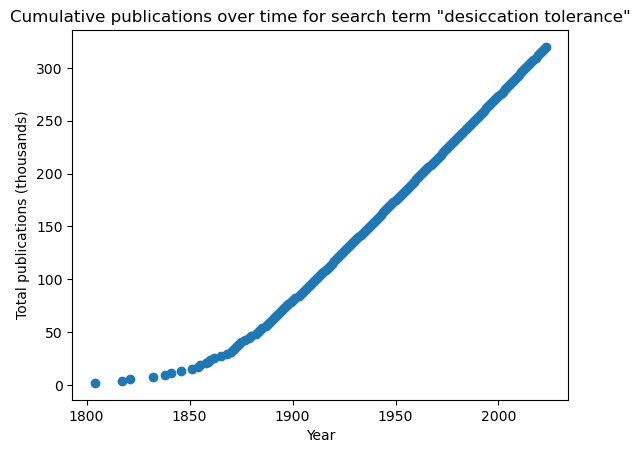

In [29]:
plt.scatter(cumulative_years.keys(), cumulative_years.values())
plt.title('Cumulative publications over time for search term "desiccation tolerance"')
plt.ylabel('Total publications (thousands)')
plt.xlabel('Year')

What does this look like if we subset by the classification that we have?

In [43]:
len(set(paper_classifications.keys()).intersection(set([p['paperId'] for p in papers_with_years if p is not None])))

167632

There are about 30,000 papers different between the 19Sep and the 23Oct paper sets. Since the classification for 23Oct is still running, we can only do this for the papers that are in common between the two sets; results should be taken with a grain of salt for the moment.

In [45]:
# Add the classifications to the dataset
for p in papers_with_years:
    if p is not None:
        try:
            p['classification'] = paper_classifications[p['paperId']]
        except KeyError:
            p['classification'] = 'missing_in_new'

In [58]:
# Separate by classification
years_per_class = defaultdict(list)
for p in papers_with_years:
    if p is not None:
        if p['year'] is not None:
            years_per_class[p['classification']].append(p['year'])

In [59]:
years_per_class.keys()

dict_keys(['Plant', 'NOCLASS', 'missing_in_new', 'Fungi', 'Animal', 'Microbe'])

We want to look both at the normal and cumulative versions:

In [60]:
colors = {'Plant': '#E69F00', 'Animal': '#56B4E9', 'Microbe': '#009E73', 'Fungi': '#F0E442', 'NOCLASS': '#CC79A7', 'missing_in_new': '#C7C7C7'}

Text(0, 0.5, 'Count')

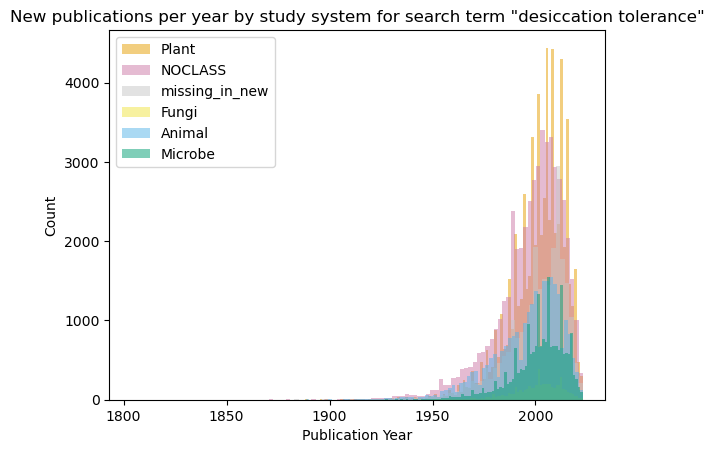

In [64]:
fig, ax = plt.subplots(1, 1)
for cls, yrs in years_per_class.items():
    _ = ax.hist(yrs, bins=100, color=colors[cls], label=cls, alpha=0.5)
plt.legend()
plt.title('New publications per year by study system for search term "desiccation tolerance"')
plt.xlabel('Publication Year')
plt.ylabel('Count')

The distributions look the same, which is great! Now let's look at the cumulative:

Text(0.5, 0, 'Year')

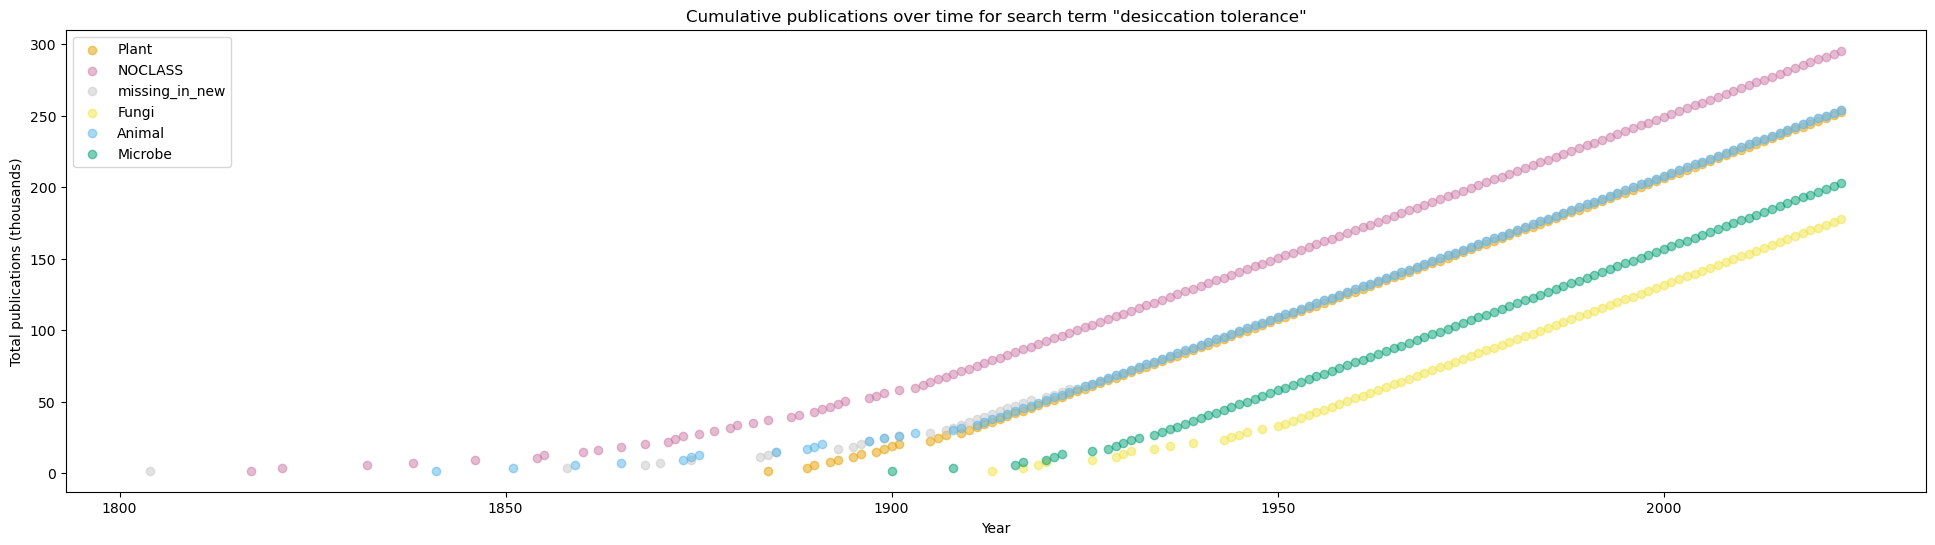

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(24,6))
for cls, yrs in years_per_class.items():
    yr_counts = Counter(yrs)
    ordered_yrs = sorted(yr_counts.keys())
    cumulative_years = {y:(ordered_yrs[i] + sum(ordered_yrs[:i]))/1000 for i, y in enumerate(ordered_yrs)}
    ax.scatter(cumulative_years.keys(), cumulative_years.values(), color=colors[cls], alpha=0.5, label=cls)
plt.legend()
plt.title('Cumulative publications over time for search term "desiccation tolerance"')
plt.ylabel('Total publications (thousands)')
plt.xlabel('Year')

I wouldn't have expected plant and animal to have such similar numbers! Again, `NOCLASS` and `missing_in_new` are accounting for such a large portion here that we have to take these with a grain of salt, but I still think this is promising.

## Topic modeling
We can perform topic modeling on titles and abstracts to get a better sense of what's in our dataset. We'll follow [this tutorial](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) to get started.

In [71]:
for_df_papers = defaultdict(list)
for pid, p in flattened_papers.items():
    for_df_papers['paperId'].append(pid)
    for_df_papers['title'].append(p['title'])
    try:
        for_df_papers['abstract'].append(p['abstract'])
    except KeyError:
        for_df_papers['abstract'].append(None)
paper_df = pd.DataFrame.from_dict(for_df_papers)

In [73]:
paper_df.head()

,paperId,title,abstract
0,393cc126bd647a8435072e788a2a033561c6fa97,Unexplored dimensions of variability in vegeta...,Desiccation tolerance has evolved recurrently ...
1,18d8e54e9f384361d3f6af634642e82d2479bef2,Expression dynamics of dehydration tolerance i...,Tolerance to prolonged water deficit occurs al...
2,2ee8adf45800831679c9ee226cf108b34197108b,Multi‐Omics Insights into the Evolution of Ang...,None
3,af0eb5272536c8b1db53e671b77d9ea61e206ff5,All for One: The Role of Colony Morphology in ...,"In the last decade, several works showed that ..."
4,2b32eec751dbe123a7532cfac4fb3c8ce5295a37,Desiccation Tolerance in Chlorophyllous Fern S...,Fern spores of most species are desiccation to...


In [78]:
# From tutorial
# Remove punctuation
paper_df['title_processed'] = paper_df['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
paper_df['title_processed'] = paper_df['title_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
paper_df['title_processed'].head()

0    unexplored dimensions of variability in vegeta...
1    expression dynamics of dehydration tolerance i...
2    multi‐omics insights into the evolution of ang...
3    all for one: the role of colony morphology in ...
4    desiccation tolerance in chlorophyllous fern s...
Name: title_processed, dtype: object

In [84]:
papers_with_abstracts = paper_df[~paper_df['abstract'].isna()].copy()

In [85]:
# From tutorial
# Remove punctuation
papers_with_abstracts['abstract_processed'] = papers_with_abstracts['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers_with_abstracts['abstract_processed'] = papers_with_abstracts['abstract_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers_with_abstracts['abstract_processed'].head()

0    desiccation tolerance has evolved recurrently ...
1    tolerance to prolonged water deficit occurs al...
3    in the last decade several works showed that e...
4    fern spores of most species are desiccation to...
5    abstract rabarimanarivo mn b ramandimbisoa nh ...
Name: abstract_processed, dtype: object